## An implementation of the Hadamard test in qiskit

This notebook contains a qiskit implementation of the Hadamard test. Please see the following article for further information: .

In [127]:
# Important packages:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
import numpy as np
from qiskit.tools.visualization import circuit_drawer

In [128]:
import qiskit
qiskit.__qiskit_version__

# Here's the used in the article.
# {'qiskit-terra': '0.23.3', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.42.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

{'qiskit-terra': '0.23.3', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.42.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [129]:
def build_circ(_circuit, _register, _params, _n_qubits, _barrier = False):
    """
    Implements a parametrized quantum circuit in the _register chosen.
    """

    for index in range(_n_qubits):
        _circuit.h(index)
        _circuit.rx(_params[index], _register[index])

    # the CNOT Layer
    for k in range(_n_qubits - 1):
        _circuit.cnot(_register[k], _register[k+1])

    if _barrier:
        _circuit.barrier()

    return _circuit

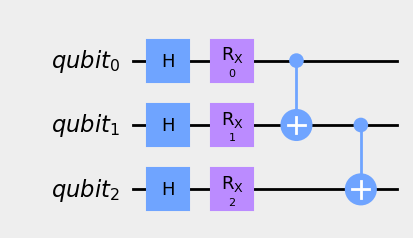

In [130]:
nqubits = 3
nb_params = nqubits

q = QuantumRegister(nqubits, 'qubit')
circ_psi = QuantumCircuit(q)

params_psi = [el for el in range(nb_params)]

circ_psi = build_circ(circ_psi, q, params_psi, nqubits, _barrier = False)

circuit_drawer(circ_psi, output='mpl', style={'backgroundcolor': '#EEEEEE'})


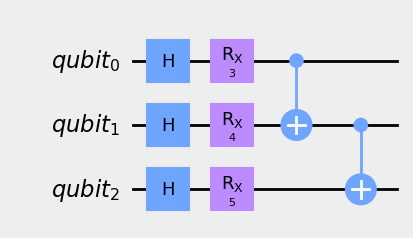

In [131]:
p = QuantumRegister(nqubits, 'qubit')
circ_phi = QuantumCircuit(p)

params_phi = [el for el in range( nb_params, 2*nb_params)]

circ_phi = build_circ(circ_phi, q, params_phi, nqubits, _barrier = False)

circuit_drawer(circ_phi, output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [132]:
def sigma_z(_circuit):
    """
    Takes in a circuit with an ancilla;
    returns the <sigma_z> of the measurements on the ancilla alone.
    """
    circuit_copy = _circuit.copy()
    c_reg = ClassicalRegister(1, "c_bit")
    circuit_copy.add_register(c_reg)

    circuit_copy.measure(0, c_reg[0])
    nb_shots = 10000

    simulator = Aer.get_backend("qasm_simulator")
    job = execute(circuit_copy, backend=simulator, shots = nb_shots)
    result = job.result()
    counts = result.get_counts()

    return (counts['0'] - counts['1'])/nb_shots

In [133]:
 # Get U_dagger_phi

U_phi_dagger = circ_phi.to_gate(label = "U_phi^dagger").inverse()
definition = [q[index] for index in range(nqubits)]
U_circ = circ_psi.copy()
U_circ.append(U_phi_dagger, definition)
U_circ.draw()



# V_circ = QuantumCircuit(_n_qubits)
#     V_circ.prepare_state(normalized_components)
#     V_gate = (V_circ).to_gate(label = "V_x").control(1)

#     definition = [anc[0]] + [potential[index] for index in range(_n_qubits)]
#     circ.append(V_gate, definition)

┌───┐┌───────┐          ┌──────────────────┐
qubit_0: ┤ H ├┤ Rx(0) ├──■───────┤0                 ├
         ├───┤├───────┤┌─┴─┐     │                  │
qubit_1: ┤ H ├┤ Rx(1) ├┤ X ├──■──┤1 circuit-2338_dg ├
         ├───┤├───────┤└───┘┌─┴─┐│                  │
qubit_2: ┤ H ├┤ Rx(2) ├─────┤ X ├┤2                 ├
         └───┘└───────┘     └───┘└──────────────────┘

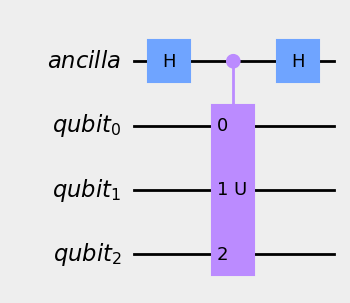

In [134]:
U_controlled_gate = (U_circ.to_gate(label = "U")).control(1)

anc = QuantumRegister(1, 'ancilla')
q = QuantumRegister(nqubits, 'qubit')
circ_Hadamard = QuantumCircuit(anc, q)
definition = [anc[0]] + [q[index] for index in range(nqubits)]

evaluate_complex_part = False

circ_Hadamard.h(anc[0])
if evaluate_complex_part:
    circ_Hadamard.sdg(anc[0])

circ_Hadamard.append(U_controlled_gate, definition)
circ_Hadamard.h(anc[0])
circuit_drawer(circ_Hadamard, output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [135]:
avg_Z = sigma_z(circ_Hadamard)
avg_Z

-0.1956

In [136]:
#ACTUAL OVERLAP

simulator = Aer.get_backend('aer_simulator')
circ_psi.save_statevector()
job = execute(circ_psi, simulator)
result = job.result()
psi_state = result.get_statevector()
psi_vector = psi_state.data
print(psi_vector)


[0.02500938-0.35266773j 0.02500938-0.35266773j 0.02500938-0.35266773j
 0.02500938-0.35266773j 0.02500938-0.35266773j 0.02500938-0.35266773j
 0.02500938-0.35266773j 0.02500938-0.35266773j]


In [137]:
circ_phi.save_statevector()
job = execute(circ_phi, simulator)
result = job.result()
phi_state = result.get_statevector()
phi_vector = phi_state.data
print(phi_vector)

[0.33947146+0.0987883j 0.33947146+0.0987883j 0.33947146+0.0987883j
 0.33947146+0.0987883j 0.33947146+0.0987883j 0.33947146+0.0987883j
 0.33947146+0.0987883j 0.33947146+0.0987883j]


In [138]:
phi_vector_dagger = phi_state.conjugate()
overlap = np.dot(phi_vector_dagger, psi_vector)
overlap

(-0.21079579943077972-0.977530117665097j)

In [139]:
def avg_error(nb_repetitions):
    results = []
    for run in range(nb_repetitions):
        results.append(sigma_z(circ_Hadamard))

    errors = [abs( (result - overlap.real )/overlap.real ) for result in results]

    return sum(errors)/len(errors)


print("Over 100 repetitions, the error was of: ",avg_error(100)*100,"%")

Over 100 repetitions, the error was of:  3.421400256667406 %
